# Performance evaluation in football: outcomes vs underlying performance

## Intro

How people evalute others' performance when the output depends on luck as well? Football is an ideal setting to study this question because its low scoring nature introducies a lat of randomness into the final results: a team playing well means that they have a higher chance of winning but it does not guarantee a win at all. In this exercise I look at player ratings given by sport magazine journalists to disantangle the importance of actual scores and underlying performance in determining the evaluations.   

## Data

Currently, I work with data from the Bundesliga. After each game, the sports magazine Kicker rates players on a 1 (best) to 7 (worst) scale. __[For example, Hoffenheim trashed Dortmund at the Signal-Iduna Park in the last round of the 2019-20 season.](https://www.kicker.de/dortmund-gegen-hoffenheim-2020-bundesliga-4588955/schema)__ Andrej Kramaric scored four goals and earned himself the top rating, while the home players received ratings closer to 5. Interestingly, Dortmund goalkeeper Roman Bürki received the best rating in the home team, Hoffenheim apparently had even more chances than the final score would suggest. I obtained the ratings data by scraping the Kicker website (`get_ratings.ipynb`). I transform the ratings to the reverse order (high values mean good performance, low values mean bad performance) beacuse I plan to add data from outher countries and this ordering is more common. 

A key challange is to measure underlying performance. I work with the now widely used expected goals (xG) metrics. In short, xG assigns a probability of scoring to each shot based on historical data. Current xG models take into account various features of the shot (distance from goal, angle, vertical ball position, goalkeeper's and defenders' position, whether it is a header or taken with strong or week foot, etc.). Then for each game, we can simply aggregate the xG values of the individual shots to get a sense of total chances created weighted by chance quality. Similarly, aggregating the xG values of the opponent's shots gives total chances conceded weighted by chance quality. __[I obtained xG data from FBref.com](https://fbref.com/en/comps/20/1634/schedule/2017-2018-Bundesliga-Scores-and-Fixtures)__  where they report values calculated by __[Statsbomb](https://statsbomb.com/)__ from the 2017-18 season (`get_xg.ipynb` collects season level data into one csv file). 

The ratings and xG data can be merged on season, round and team. As the two datasets come from different sources, team names are coded differently. Fortunatrely, we have only a handful of teams so it was easy to match their names manually (`team_names.csv`). 


In [57]:
### Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns


### Set graph style
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})


### Import data files
df_ratings = pd.read_csv('input/ratings_bundesliga.csv')[['season', 'round', 'team', 'player_name', 'rating', 'start']].rename(columns={'team': 'team_ratings'})
df_xg = pd.read_csv('input/xg_bundesliga.csv').drop(columns=['match_id', 'home']).rename(columns={'team': 'team_xg'})
team_names = pd.read_csv('input/team_names.csv')


### Calculate average rating
df_ratings['rating'] = df_ratings['rating'].str.replace(',', '.').astype(float)
df_ratings['rating'] = 8 - df_ratings['rating']

df_ratings['position']=df_ratings.groupby(['season', 'round', 'team_ratings']).cumcount()

df_ratings['rating_start'] = df_ratings.loc[df_ratings['position'].isin(list(range(11))), 'rating']
df_ratings['rating_goalkepper']    = df_ratings.loc[df_ratings['position']==0, 'rating']
df_ratings['rating_defence']   = df_ratings.loc[df_ratings['position'].isin(list(range(1, 6))), 'rating']
df_ratings['rating_attack']   = df_ratings.loc[df_ratings['position'].isin(list(range(6, 11))), 'rating']

cols = [col for col in df_ratings.columns if ('rating' in col) or (col in ['season', 'round', 'team_ratings'])]
df_ratings_agg = df_ratings[cols].groupby(['season', 'round', 'team_ratings']).mean().reset_index()

### Merge xg and ratings
df_ratings_agg = pd.merge(df_ratings_agg, team_names, how='inner', on='team_ratings')
df = pd.merge(df_ratings_agg, df_xg, how='inner', on=['team_xg', 'season', 'round'])


### Calculate variables
df['score_diff'] = df['score'] - df['score_against'] 
df['win'] = (df['score_diff'] > 0).astype(int)
df['loose'] = (df['score_diff'] < 0).astype(int)
df['xg_diff'] = df['xg'] - df['xg_against'] 
df['xg_diff_round'] = df['xg_diff'].round().astype(int)
df['const'] = 1

### Check the xG model

Before looking at the relationship between ratings and xG, I show that actual scores are indeed centered around the xG values. I plot goals scoared against xG. The dot size indicates the number of observation for the given instances (I will use this throughout the entire exercise). We expect that the fitted line has zero intercept and slope of 1 which is exatcly what the get (see the regression output below).

<AxesSubplot:xlabel='xg', ylabel='score'>

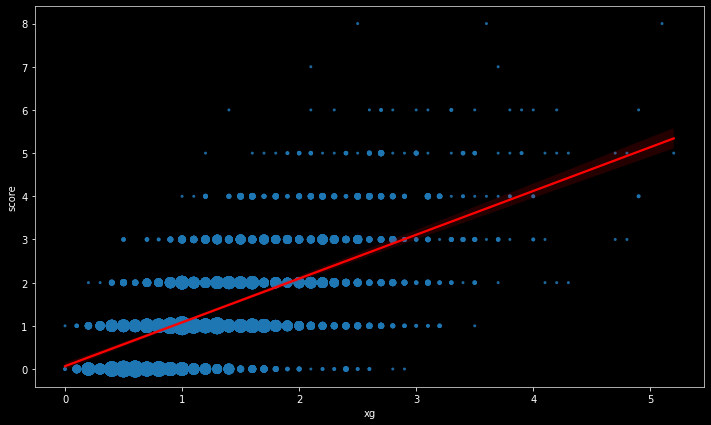

In [58]:
### Score vs xg - figures

msize=4
fig, ax1 = plt.subplots(1, 1, figsize=(12,7))

df_counts = df.groupby(['xg', 'score'])['season'].count().reset_index().rename(columns={'season': 'count'} )
df_with_counts = pd.merge(df, df_counts, on=['xg', 'score'], how='inner')
sns.regplot(x='xg', y='score', data=df_with_counts, ax=ax1, line_kws={'color': 'red'}, scatter_kws={'s': df_with_counts['count']*msize})


In [59]:
### Score vs xg - regression

model = sm.OLS(df['score'], df[['xg', 'const']])
reg1 = model.fit()

results = summary_col(reg1, stars=True, float_format='%0.2f',
                      #model_names=['(0)','(1)\nHC3','(2)\nCluster'],
                      info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)), 
                      #           'R2':lambda x: "{:.2f}".format(x.rsquared)
                                }
                     )
print(results)



                score 
----------------------
xg             1.01***
               (0.03) 
const          0.07   
               (0.04) 
R-squared      0.39   
R-squared Adj. 0.39   
N              2448   
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


In [60]:
### Ratings vs scores or xg - figures

def ratings_scatter(xvar, msize=8, figheight=12, figwidth=18):
    
    xvar_against = xvar+'_against'
    xvar_diff = xvar+'_diff'
    xvarlist = [xvar, xvar_against, xvar_diff]
    
    fig, axs = plt.subplots(2, 2)
    
    for x in xvarlist:
        df_counts = df.groupby([x, 'rating'])['season'].count().reset_index().rename(columns={'season': 'count'} )
        df_with_counts = pd.merge(df, df_counts, on=[x, 'rating'], how='inner')

        if x == xvarlist[0]:
            i = 0
            j = 0
        if x == xvarlist[1]:
            i = 0
            j = 1
        if x == xvarlist[2]:
            i = 1
            j = 0

        sns.regplot(x=x, y='rating', data=df_with_counts, ax=axs[i, j], line_kws={'color': 'red'}, scatter_kws={'s': df_with_counts['count']*msize})
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel('rating')


    df_counts = df.groupby([xvar, xvar_against])['season'].count().reset_index().rename(columns={'season': 'count'} )
    df_with_counts = pd.merge(df, df_counts, on=[xvar, xvar_against], how='inner')

    df_with_counts.plot(
        x=xvar, y=xvar_against,
        kind='scatter', figsize=(10,7), ax=axs[1,1],
        s=df_with_counts['count']*msize/2, alpha=.4,
        c='rating', cmap=plt.get_cmap('jet'), colorbar=True
    )

    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    
    return


## Ratings vs scores

First, let's look at the relationship between ratings and scores. Avarege team rating is higher when the team scores more (top left) or concedes less (top right). These two effects are summarized in the bottom right figure where I plot goals scored and conceded together. Finally, we can aggregate them into a single measure, score difference (bottom left).   

c:\users\krusp\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


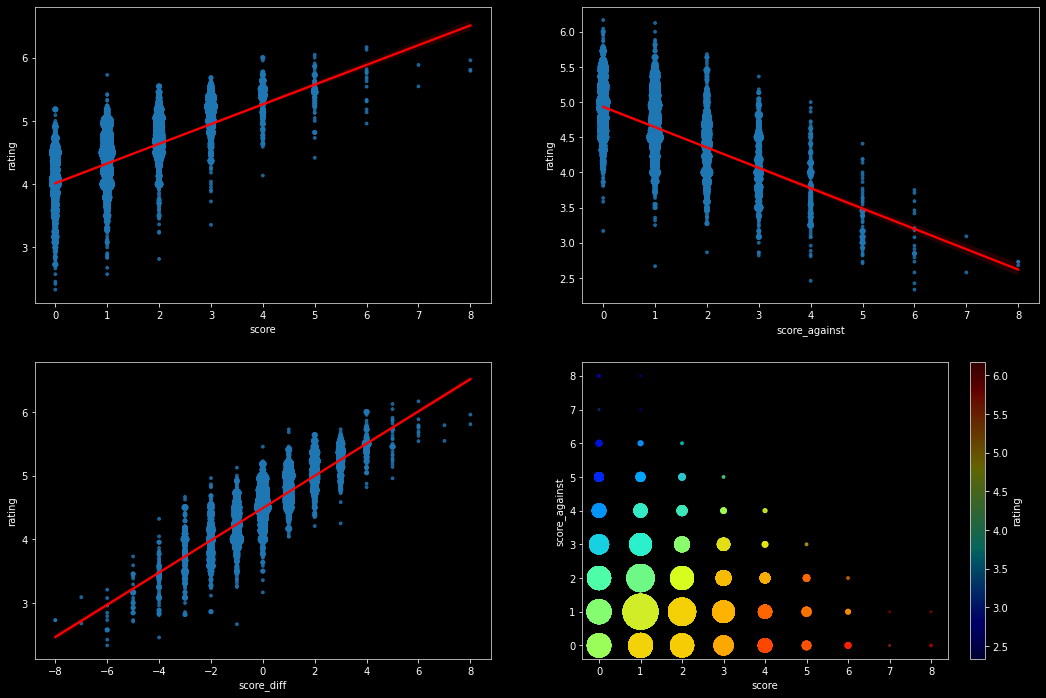

In [61]:
### Ratings vs score - figures
ratings_scatter(xvar='score')


## Ratings vs xG

Now, let's see change actual scores to expected goals on the horizontal axes. We get similar pattarens: Avarege team rating is higher when the team creates more chances (top left) or denies opponents from creating chances (top right). The two effects are summarized in the bottom right figure where I plot xG and opponents's xG together. Finally, we can aggregate them into a single measure, xG difference (bottom left).

c:\users\krusp\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


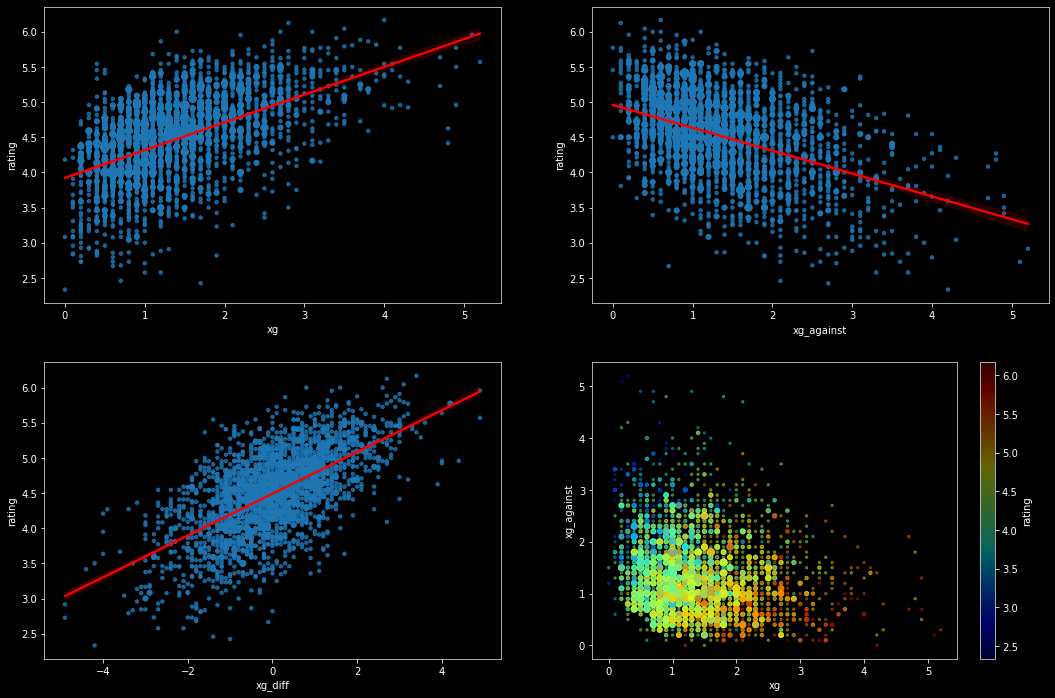

In [62]:
### Ratings vs xg - figures
ratings_scatter(xvar='xg', msize=12)


## Actual scores are more important than xG

So far we have seen that both acutal scores and xG correlates positively with rankings. Now let's look at their effect simultaneously so we can judge which one is more important. To create a comprehensible figure, I make two adjustments to the data. First, I round xG difference to aggregate observations into fewer categories. Second, I drop outliers (games where the score difference is larger than 6 or the xG difference is larger than 4). 

The heatmap below indicates averege team ratings for each pair of score differences and rounded xG differences. As expected, we observe higher ratings in the top right corner (teams creating more chances and scoring  more goals relative to opponent) and lower ratings in the bottom left corner (teams creating less chnaces and scoring less goals relative to opponent).

We can read the relative importance of actuals scores and xG if we move horizontally or vertically on the figure. 
 - We can compare games where the result is the same but the xG difference is larger by moving from left to right within a single row. For example, when the result is a draw, moving from an xG difference from -4 to 4 increases the ratings only slightly (from 4.3 to 4.6). 
 - Similarly, we can compare games where the xG difference is the same but the score difference is larger by moving from bottom to top within a single column. For example, when the teams created similar amount of chances (rounded xG difference is 0) , moving from a 4 goal defeat to a 4 goal win increases the ratings significantly (from 3.5 to 5.4)

<AxesSubplot:xlabel='xg_diff_round', ylabel='score_diff'>

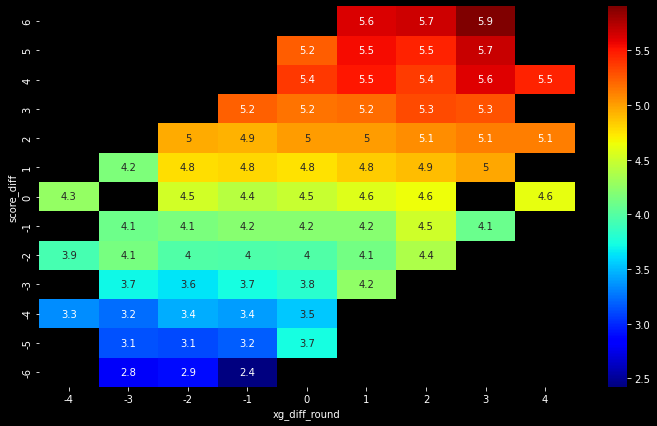

In [63]:
### Ratings vs score and xg - figures

df_restricted = df[(abs(df['xg_diff'])<=4) & (abs(df['score_diff'])<=6)]

ratings = df_restricted[['xg_diff_round', 'score_diff', 'rating']].groupby(['xg_diff_round', 'score_diff']).mean().unstack(level=0).sort_index(ascending=False)
ratings.columns = ratings.columns.droplevel()

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(ratings, annot=True, cmap=plt.get_cmap('jet'), alpha=1, ax=ax)


## Win or loose

Intuitively, the success of a team is not linear in the score difference: the value of an additional goal is larger when it makes the difference between a draw and a close win than when the team would have won the game anyway. Do ratings reflect this relationship? 

I plot average ratings as a function of the score difference. To zoom in the neighborhood of draws I exclude games where the score difference is larger 4, the results are not sensitive to the sample restriction. 
 - First, I use data from defeats and predict ratings for the draws (indicated by the dashed line). We can see that actual ratings are higher, there is am extra premium for improving score difference by one when it turns a defeat into a draw.
 - Then I repeated the same procedure for victories. Actual ratings are now lower than predicted, meaning that there is an extra premium for improving score difference by one when it turns a draw into a victory.

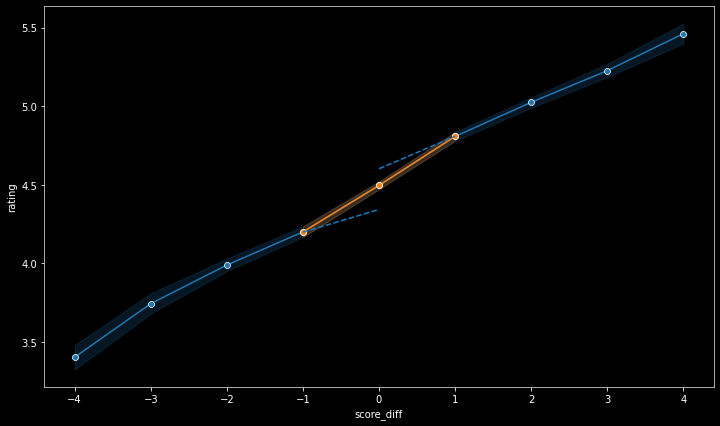

In [64]:
### Ratings vs score and win/loose

cutoff = 4
df2 = df.loc[abs(df['score_diff'])<=cutoff, ['rating', 'score_diff', 'const']]
df2['score_diff2'] = df2['score_diff'] ** 2


### Predict draw ratings from lost games
y = df2.loc[df2['score_diff']<=-1, 'rating']
x = df2.loc[df2['score_diff']<=-1, ['score_diff', 'score_diff2']]
x = sm.add_constant(x)
model = sm.OLS(y, x)
reg = model.fit()

x_pred = df2[['score_diff', 'score_diff2']]
x_pred = sm.add_constant(x_pred)
df2['rating_pred_loose'] = reg.predict(x_pred)


### Predict draw ratings from won games
y = df2.loc[df2['score_diff']>=1, 'rating']
x = df2.loc[df2['score_diff']>=1, ['score_diff', 'score_diff2']]
x = sm.add_constant(x)
model = sm.OLS(y, x)
reg = model.fit()

x_pred = df2[['score_diff', 'score_diff2']]
x_pred = sm.add_constant(x_pred)
df2['rating_pred_win'] = reg.predict(x_pred)


fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.lineplot(data=df2, x='score_diff', y='rating', style='const', markers=True, legend=False)
ax = sns.lineplot(data=df2[abs(df2['score_diff'])<=1], x='score_diff', y='rating', style='const', markers=True, legend=False)
ax = sns.lineplot(data=df2[df2['score_diff'].isin([-1, 0])], x='score_diff', y='rating_pred_loose', legend=False, color=sns.color_palette()[0])
ax = sns.lineplot(data=df2[df2['score_diff'].isin([0, 1])], x='score_diff', y='rating_pred_win', legend=False, color=sns.color_palette()[0])
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")


## Regression analysis

I run some simple regressions to quantify the effect of scores and xG on ratings. For all specification, the unit of observation is season-round-team and the dependent variable is average team rating. 

 - Column 1 shows that actual scores are more important than expected goals. Increasing actual goal difference by 1 increases average ratings by 0.23 while increasing expected goal difference by 1 increases average ratings only by 0.04. 

 - Column 2 breaks down the effect of score difference to goals scored/conceded and the effect of xG difference to chances created/conceded. In terms of ratings, scoring an addititional goal is equivalent to conceding one goal less. Interestingly, this symmetry does not hold for xG: creating chances is rewarded while deniing chances from the opponent has no effect. 

 - Column 3 adds a dummy for winning and loosing the game. The penalty for defeats is higher (0.10) than the reward for victories (0.05). The other coefficients are unchanged.  

To summarize, regression results confirm what we saw on the graphs, actual scores are more important than expected goals. 

In [65]:
### Ratings regressions

model = sm.OLS(df['rating'], df[['score_diff', 'xg_diff', 'const']])
reg1 = model.fit()

model = sm.OLS(df['rating'], df[['score', 'score_against', 'xg', 'xg_against', 'const']])
reg2 = model.fit()

model = sm.OLS(df['rating'], df[['score', 'score_against', 'xg', 'xg_against', 'win', 'loose', 'const']])
reg3 = model.fit()

results = summary_col([reg1, reg2, reg3], stars=True, float_format='%0.2f',
                      model_names=['(1)\nrating', '(2)\nrating', '(3)\nrating'],
                      info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))},
                      regressor_order=['score_diff', 'score', 'score_against', 'xg_diff', 'xg', 'xg_against', 'win', 'loose', 'const']                 
                     )
print(results)



                 (1)     (2)      (3)   
                rating  rating   rating 
----------------------------------------
R-squared      0.73    0.73     0.73    
R-squared Adj. 0.73    0.73     0.73    
const          4.49*** 4.36***  4.38*** 
               (0.01)  (0.02)   (0.02)  
loose                           -0.10***
                                (0.02)  
score                  0.23***  0.21*** 
                       (0.01)   (0.01)  
score_against          -0.24*** -0.21***
                       (0.01)   (0.01)  
score_diff     0.23***                  
               (0.00)                   
win                             0.05**  
                                (0.02)  
xg                     0.09***  0.09*** 
                       (0.01)   (0.01)  
xg_against             0.00     -0.00   
                       (0.01)   (0.01)  
xg_diff        0.04***                  
               (0.01)                   
N              2448    2448     2448    
Standard errors

## The results are stable over time

I estimate the regressions separately for each season and plot the coefficient estimates in the figure below. Dashed line represent coefficient estimates for the entire sample. There is not much going on, the coefficients are stable over time. This is somewhat surprising in light of the recent success of the xG metrics: it broke out from the circles of football analytics and became part of the mainstraim football media in recent years. At the same time, its influence on retings remained low compared to actual scores. 

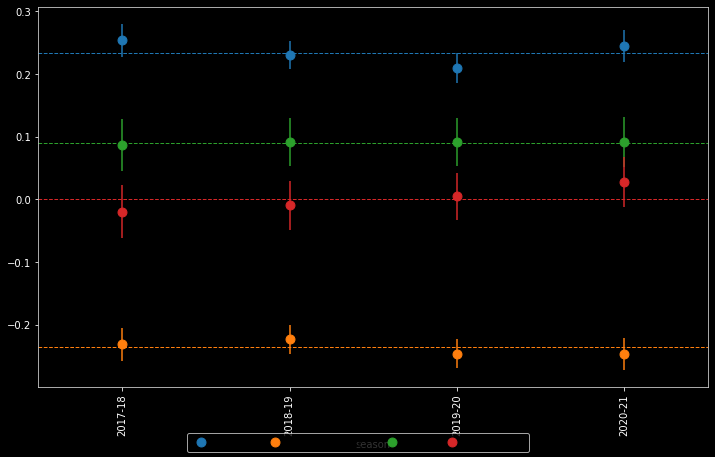

In [67]:
### Ratings vs scores and xg over time

# Estimate regressions by seasons
xvars = ['const', 'score', 'score_against', 'xg', 'xg_against']

regs = dict()
coefs = dict()

model = sm.OLS(df['rating'], df[xvars])
regs['all'] = model.fit()

for i in df['season'].unique():
    model = sm.OLS(df.loc[df['season']==i, 'rating'], df.loc[df['season']==i, xvars])
    regs[i] = model.fit()
    error= regs[i].params - regs[i].conf_int()[0]
    coefs[i] = pd.DataFrame({'coef': regs[i].params.values,
                             'error': error.values,
                             'varname': error.index.values,
                             'season': i
                            })

# Plot coefficients
coefs_all = pd.concat(list(coefs.values())).sort_values('season')
fig, ax = plt.subplots(figsize=(12, 7))

for i, var in enumerate(xvars[1:]):
    coef_df = coefs_all[coefs_all['varname']==var]

    coef_df.plot(x='season', y='coef', kind='bar',
                 ax=ax, color='none', 
                 ecolor=sns.color_palette()[i] ,capsize=0, label='_nolegend_',
                 yerr='error', legend=False)

    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color=sns.color_palette()[i], label=var)
    
    ax.axhline(y=regs['all'].params[var], linestyle='--', color=sns.color_palette()[i], linewidth=1)

fig.legend(loc='lower center', ncol=len(xvars[1:]))


## Goalkeepers, defenders, attackers

Finally, I look at players in differnet positions. Again, I estimate the same regression but now I change the dependent variable. Specifically, I use average ratings for different sets of players: staring eleven, goalkeepers, defenders, attackers. I don't have data on player positions (yet), I use the order in which players appear in the Kicker website as a proxy (traditionally the lineup is listed from the back to forwards). I plot the coefficient estimates in the figure below (dashed line represent coefficients estimated for average team rating). 

Dropping the ratings of substitute players is more of a robustness check, it doesn't change the coefficients at all. It suggests that results are not affected by the fact that teams make substitutions differenetly based on the actual stading of the game.

Now let's look at defenders and attackers. On the first hand, the previous finding holds, actual scores are more important than xG for both defenders and attackers. On the other hand, goals and chances conceded have a larger effect on defenders while goals scored and chances created have a larger effect on attackers. 

Finally, goalkeepers are a completely different story. Not surprisingly, attacking performance has no effect and they are punished for letting in goals. Chances created by the opponents has a positive coeffeicient, goalkeppers are rewarded when they concede the same number of goals from more chances created by the opponent. Defenders are rewarded for preventing opponents from making shots, while goalkeppers are rewarded for saving the shots. Note that goalkeepers are the only players whose ratings depend equally on actual scores and expected goals. 


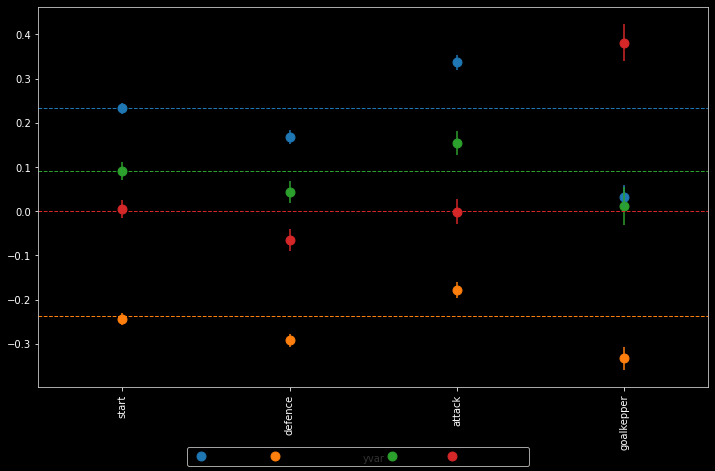

In [68]:
### Estimate the effect of score and xg for different ratings

yvars = ['rating', 'rating_start', 'rating_defence', 'rating_attack', 'rating_goalkepper']
xvars = ['const', 'score', 'score_against', 'xg', 'xg_against']


regs = dict()
coefs = dict()

for y in yvars:
    model = sm.OLS(df.loc[df[y].notna(), y], df.loc[df[y].notna(), xvars])
    regs[y] = model.fit()
    error= regs[y].params - regs[y].conf_int()[0]
    coefs[y] = pd.DataFrame({'coef': regs[y].params.values,
                             'error': error.values,
                             'varname': error.index.values,
                             'yvar': y
                            })

# Plot coefficients
coefs_all = pd.concat(list(coefs.values()))
coefs_all = coefs_all[coefs_all['yvar'] != 'rating']
coefs_all['yvar'] = coefs_all['yvar'].str.replace('rating_', '')
fig, ax = plt.subplots(figsize=(12, 7))

for i, var in enumerate(xvars[1:]):
    coef_df = coefs_all[coefs_all['varname']==var]

    coef_df.plot(x='yvar', y='coef', kind='bar',
                 ax=ax, color='none', 
                 ecolor=sns.color_palette()[i] ,capsize=0, label='_nolegend_',
                 yerr='error', legend=False)

    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color=sns.color_palette()[i], label=var)
    
    ax.axhline(y=regs['rating'].params[var], linestyle='--', color=sns.color_palette()[i], linewidth=1)

fig.legend(loc='lower center', ncol=len(xvars[1:]))
